## Our goal 
Goal is clear and simple. We need to build a model, which can classify between healthy and diseased crop leaves and also if the crop have any disease, predict which disease is it.

## Importing necessary libraries

Let's import required modules

In [24]:
import warnings
warnings.filterwarnings('ignore')

In [25]:
pip install torchsummary

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [27]:
import os                       # for working with files
import numpy as np              # for numerical computationss
import pandas as pd             # for working with dataframes
import torch                    # Pytorch module 
import matplotlib.pyplot as plt # for plotting informations on graph and images using tensors
import torch.nn as nn           # for creating  neural networks
from torch.utils.data import DataLoader # for dataloaders 
from PIL import Image           # for checking images
import torch.nn.functional as F # for functions for calculating loss
import torchvision.transforms as transforms   # for transforming images into tensors 
from torchvision.utils import make_grid       # for data checking
from torchvision.datasets import ImageFolder  # for working with classes and images
from torchsummary import summary              # for getting the summary of our model

%matplotlib inline

## Exploring the data 

Loading the data 

In [31]:
data_dir = "../input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)"
train_dir = data_dir + "/train"
valid_dir = data_dir + "/valid"
diseases = os.listdir(train_dir)

In [32]:
print(diseases)

['Tomato___Late_blight', 'Tomato___healthy', 'Grape___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Potato___healthy', 'Corn_(maize)___Northern_Leaf_Blight', 'Tomato___Early_blight', 'Tomato___Septoria_leaf_spot', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Strawberry___Leaf_scorch', 'Peach___healthy', 'Apple___Apple_scab', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Tomato___Bacterial_spot', 'Apple___Black_rot', 'Blueberry___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Peach___Bacterial_spot', 'Apple___Cedar_apple_rust', 'Tomato___Target_Spot', 'Pepper,_bell___healthy', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Potato___Late_blight', 'Tomato___Tomato_mosaic_virus', 'Strawberry___healthy', 'Apple___healthy', 'Grape___Black_rot', 'Potato___Early_blight', 'Cherry_(including_sour)___healthy', 'Corn_(maize)___Common_rust_', 'Grape___Esca_(Black_Measles)', 'Raspberry___healthy', 'Tomato___Leaf_Mold', 'Tomato__

In [33]:
print("Total disease classes are: {}".format(len(diseases)))

Total disease classes are: 38


In [38]:
plants = []
Diseases = []
NumberOfDiseases = 0
for plant in diseases:
    if plant.split('___')[0] not in plants:
        plants.append(plant.split('___')[0])
    if plant.split('___')[1] != 'healthy':
        NumberOfDiseases += 1
        Diseases.append(plant.split('___')[1])

The above cell extract the number of unique plants and number of unique diseases while omitting the healthy leaves.

In [40]:
# unique plants in the dataset
print(f"Unique Plants are: \n{plants}")

Unique Plants are: 
['Tomato', 'Grape', 'Orange', 'Soybean', 'Squash', 'Potato', 'Corn_(maize)', 'Strawberry', 'Peach', 'Apple', 'Blueberry', 'Cherry_(including_sour)', 'Pepper,_bell', 'Raspberry']


In [41]:
# number of unique plants
print("Number of plants: {}".format(len(plants)))

Number of plants: 14


In [42]:
print(f"Unique Diseases are: \n{Diseases}")

Unique Diseases are: 
['Late_blight', 'Haunglongbing_(Citrus_greening)', 'Powdery_mildew', 'Northern_Leaf_Blight', 'Early_blight', 'Septoria_leaf_spot', 'Cercospora_leaf_spot Gray_leaf_spot', 'Leaf_scorch', 'Apple_scab', 'Tomato_Yellow_Leaf_Curl_Virus', 'Bacterial_spot', 'Black_rot', 'Powdery_mildew', 'Bacterial_spot', 'Cedar_apple_rust', 'Target_Spot', 'Leaf_blight_(Isariopsis_Leaf_Spot)', 'Late_blight', 'Tomato_mosaic_virus', 'Black_rot', 'Early_blight', 'Common_rust_', 'Esca_(Black_Measles)', 'Leaf_Mold', 'Spider_mites Two-spotted_spider_mite', 'Bacterial_spot']


In [43]:
# number of unique diseases
print("Number of diseases: {}".format(NumberOfDiseases))

Number of diseases: 26


## Data Preparation for training 

In [47]:
# datasets for validation and training
train = ImageFolder(train_dir, transform=transforms.ToTensor())
valid = ImageFolder(valid_dir, transform=transforms.ToTensor()) 

`torchvision.datasets` is a class which helps in loading all common and famous datasets. It also helps making our own datasets using custom data. Using `torchvision.datasets.ImageFolder` we just saved the images into two folders in this case train and valid.

#### Image shape 

In [52]:
img, label = train[0]
print(img.shape, label)

torch.Size([3, 256, 256]) 0


In [53]:
# total number of classes in train set
len(train.classes)

38

In [54]:
# for checking some images from training dataset
def show_image(image, label):
    print("Label :" + train.classes[label] + "(" + str(label) + ")")
    plt.imshow(image.permute(1, 2, 0))

Label :Apple___Apple_scab(0)


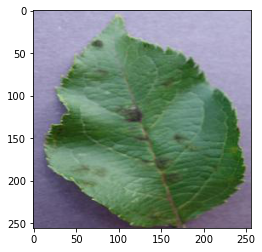

In [55]:
show_image(*train[0])

Label :Tomato___healthy(37)


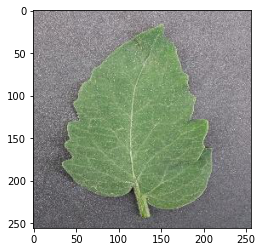

In [56]:
show_image(*train[70000])

In [61]:
# Setting the seed value
random_seed = 10
torch.manual_seed(random_seed)

In [62]:
# setting the batch size
batch_size = 32

In [63]:
# DataLoaders for training and validation
train_dl = DataLoader(train, batch_size, shuffle=True, num_workers=2, pin_memory=True)
valid_dl = DataLoader(valid, batch_size, num_workers=2, pin_memory=True)

` DataLoader` loads the data from the folders we created, while loading we set `shuffle=True` which shuffles our data. This helps us making our model more robust by not choosing batches that are similar or alike. ` num_workers ` is used to generate batches in profile.

In [64]:
# helper function to show a batch of training instances
def show_batch(data):
    for images, labels in data:
        fig, ax = plt.subplots(figsize=(30, 30))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=8).permute(1, 2, 0))
        break

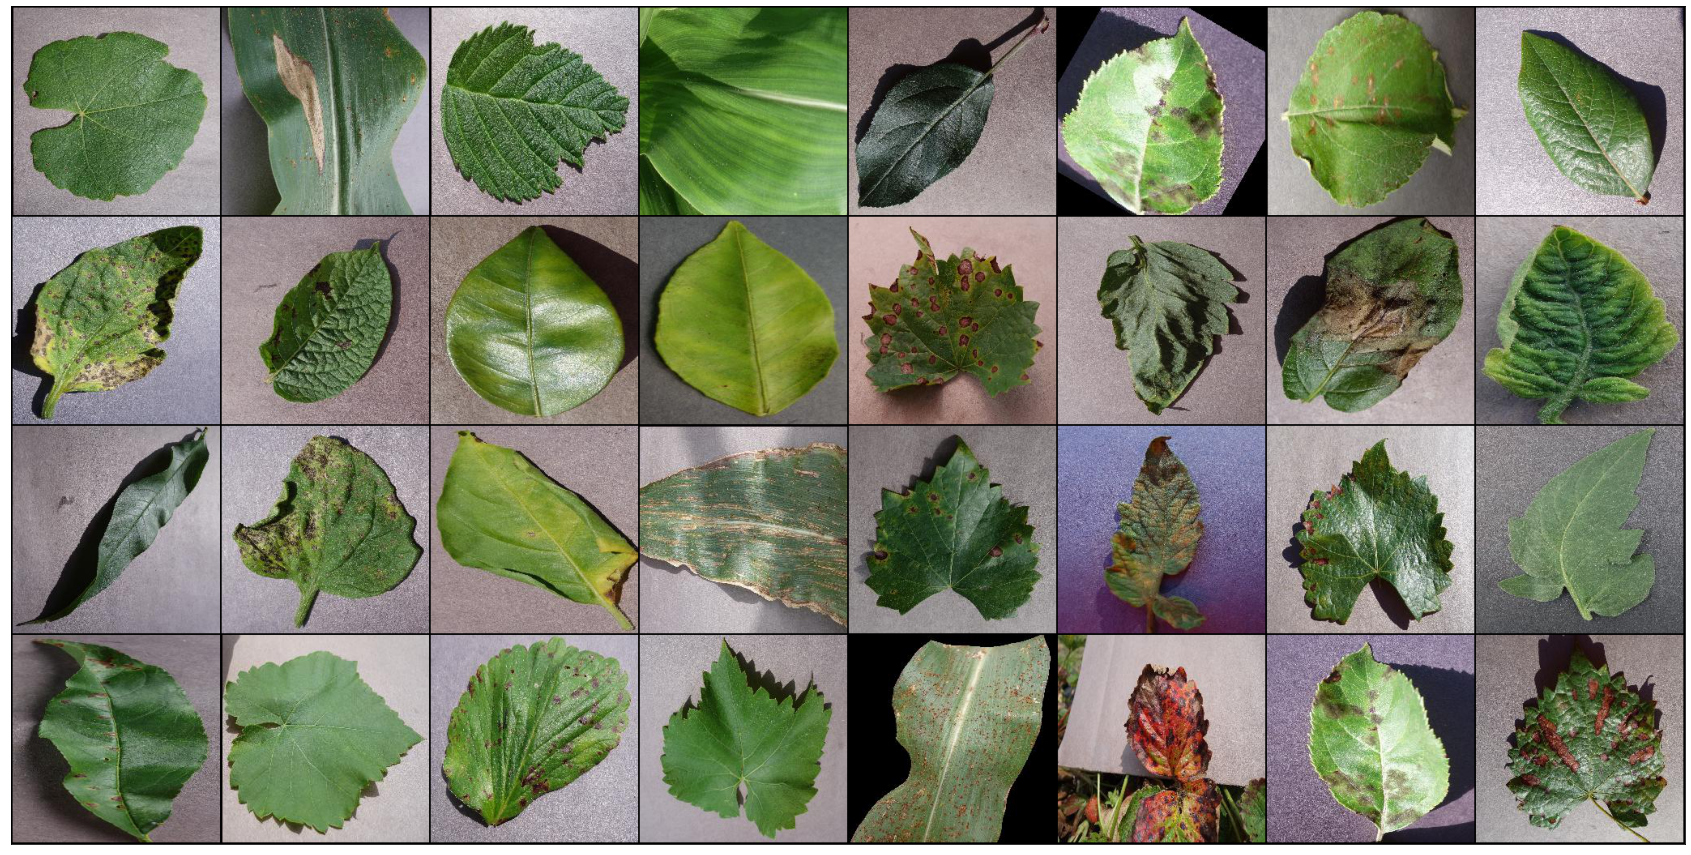

In [65]:
# Images for first batch of training
show_batch(train_dl) 

The above is the first batch which contains 32 images that is chosen for the first epoch.

## Modelling

#### Checking which device we're working with and giving priority to GPU if available. Since the data we're working with is images it's better to use GPU than CPU since CPU is meant for general purpose and using CPU for image will be costly and time consuming.

In [69]:
# for moving data into GPU (if available)
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available:
        return torch.device("cuda")
    else:
        return torch.device("cpu")

# for moving data to device (CPU or GPU)
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

# for loading in the device (GPU if available else CPU)
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)
        
    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [70]:
device = get_default_device()
device

device(type='cuda')

In [71]:
# Moving data into GPU
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

## 👷 Building the model architecture 👷

For this Plant Disease Classification we'll be using **ResNet** for this time. The difference between normal Neural Networks and Residual Networks is the addition of **Identity-Skip-Connection**. What happens in Neural Networks is that there is a lot of layers and our process is passed through this layer and we obtain some useful information, however this could also lead to **Vanishing Gradient Problem** which is caused due to over-complexity inside the layer. To avoid this problem we use the skip & using this skip doesn't lose any information and passing this to another connection we could possible infer what the complexity in the previous layers were. Here's a simple residual block:

![image](https://www.mdpi.com/remotesensing/remotesensing-11-01896/article_deploy/html/images/remotesensing-11-01896-g001.png)

#### Residual Block code implementation

In [72]:
class SimpleResidualBlock(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        
    def forward(self, x):
        out = self.conv1(x)
        out = self.relu1(out)
        out = self.conv2(out)
        return self.relu2(out) + x # ReLU can be applied before or after adding the input

**Then we define our `ImageClassificationBase` class whose functions are:**

- `training_step` - To figure out how “wrong” the model is going after training or validation step.We are using this function other than just an accuracy metric that is likely not going to be differentiable (this would mean that the gradient can’t be determined, which is necessary for the model to improve during training)

- `validation_step` - Because an accuracy metric can’t be used while training the model, doesn’t mean it shouldn’t be implemented! Accuracy in this case would be measured by a threshold, and counted if the difference between the model’s prediction and the actual label is lower than that threshold.
- `validation_epoch_end` - We want to track the validation losses/accuracies and train losses after each epoch, and every time we do so we have to make sure the gradient is not being tracked.
- `epoch_end` - We also want to print validation losses/accuracies, train losses and learning rate too because we are using learning rate scheduler (which will change the learning rate after every batch of training) after each epoch.

We also define an `accuracy` function which calculates the overall accuracy of the model on an entire batch of outputs, so that we can use it as a metric in `fit_one_cycle`

In [75]:
# for calculating the accuracy
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))


# base class for the model
class ImageClassificationBase(nn.Module):
    
    def training_step(self, batch):
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                   # Generate prediction
        loss = F.cross_entropy(out, labels)  # Calculate loss
        acc = accuracy(out, labels)          # Calculate accuracy
        return {"val_loss": loss.detach(), "val_accuracy": acc}
    
    def validation_epoch_end(self, outputs):
        batch_losses = [x["val_loss"] for x in outputs]
        batch_accuracy = [x["val_accuracy"] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()       # Combine loss  
        epoch_accuracy = torch.stack(batch_accuracy).mean()
        return {"val_loss": epoch_loss, "val_accuracy": epoch_accuracy} # Combine accuracies
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_accuracy']))
        

## Defining the final architecture of our model

In [76]:
# Architecture for training

# convolution block with BatchNormalization
def ConvBlock(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
             nn.BatchNorm2d(out_channels),
             nn.ReLU(inplace=True)]
    if pool:
        layers.append(nn.MaxPool2d(4))
    return nn.Sequential(*layers)


# resnet architecture 
class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_diseases):
        super().__init__()
        
        self.conv1 = ConvBlock(in_channels, 64)
        self.conv2 = ConvBlock(64, 128, pool=True) # out_dim : 128 x 64 x 64 
        self.res1 = nn.Sequential(ConvBlock(128, 128), ConvBlock(128, 128))
        
        self.conv3 = ConvBlock(128, 256, pool=True) # out_dim : 256 x 16 x 16
        self.conv4 = ConvBlock(256, 512, pool=True) # out_dim : 512 x 4 x 44
        self.res2 = nn.Sequential(ConvBlock(512, 512), ConvBlock(512, 512))
        
        self.classifier = nn.Sequential(nn.MaxPool2d(4),
                                       nn.Flatten(),
                                       nn.Linear(512, num_diseases))
        
    def forward(self, xb): # xb is the loaded batch
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out        

Now, we define a model object and transfer it into the device with which we are working...

In [137]:
# defining the model and moving it to the GPU
model = to_device(ResNet9(3, len(train.classes)), device) 
model

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

*Getting a nicely formatted summary of our model (like in Keras). Pytorch doesn't support it natively. So, we need to install the `torchsummary` library (discussed earlier)*

In [ ]:
# getting summary of the model
INPUT_SHAPE = (3, 256, 256)
print(summary(model.cuda(), (INPUT_SHAPE)))

## Training the model

Before we train the model, Let’s define a utility functionan `evaluate` function, which will perform the validation phase, and a `fit_one_cycle` function which will perform the entire training process. In `fit_one_cycle`, we have use some techniques:

- **Learning Rate Scheduling**: Instead of using a fixed learning rate, we will use a learning rate scheduler, which will change the learning rate after every batch of training. There are many strategies for varying the learning rate during training, and the one we’ll use is called the *“One Cycle Learning Rate Policy”*, which involves starting with a low learning rate, gradually increasing it batch-by-batch to a high learning rate for about 30% of epochs, then gradually decreasing it to a very low value for the remaining epochs.

- **Weight Decay**: We also use weight decay, which is a regularization technique which prevents the weights from becoming too large by adding an additional term to the loss function. 

- **Gradient Clipping**: Apart from the layer weights and outputs, it also helpful to limit the values of gradients to a small range to prevent undesirable changes in parameters due to large gradient values. This simple yet effective technique is called gradient clipping.

We'll also record the learning rate used for each batch.

In [78]:
# for training
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)


def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']
    

def fit_OneCycle(epochs, max_lr, model, train_loader, val_loader, weight_decay=0,
                grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # scheduler for one cycle learniing rate
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, steps_per_epoch=len(train_loader))
    
    
    for epoch in range(epochs):
        # Training
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            # gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
                
            optimizer.step()
            optimizer.zero_grad()
            
            # recording and updating learning rates
            lrs.append(get_lr(optimizer))
            sched.step()
            
    
        # validation
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
        
    return history
    

Let's check our validation loss and accuracy

In [79]:
%%time
history = [evaluate(model, valid_dl)]
history

CPU times: user 44.8 s, sys: 4.51 s, total: 49.3 s
Wall time: 1min 43s


[{'val_loss': tensor(3.6386, device='cuda:0'), 'val_accuracy': tensor(0.0273)}]

Since there are randomly initialized weights, that is why accuracy come to near 0.019 (that is 1.9% chance of getting the right answer or you can say model randomly chooses a class).
Now, declare some hyper parameters for the training of the model. We can change it if result is not satisfactory.

In [80]:
epochs = 2
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [81]:
%%time
history += fit_OneCycle(epochs, max_lr, model, train_dl, valid_dl, 
                             grad_clip=grad_clip, 
                             weight_decay=1e-4, 
                             opt_func=opt_func)

Epoch [0], last_lr: 0.00812, train_loss: 0.7291, val_loss: 0.5232, val_acc: 0.8397
Epoch [1], last_lr: 0.00000, train_loss: 0.1250, val_loss: 0.0265, val_acc: 0.9916
CPU times: user 11min 53s, sys: 7min 17s, total: 19min 10s
Wall time: 20min 3s


## Plotting

#### Helper functions for plotting

In [82]:
def plot_accuracies(history):
    accuracies = [x['val_accuracy'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');
    
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');

## Validation Accuracy

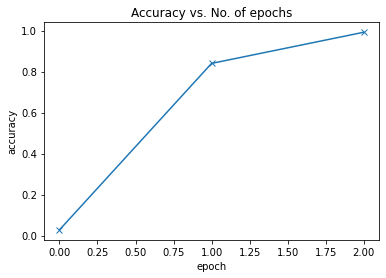

In [83]:
plot_accuracies(history)

## Validation loss

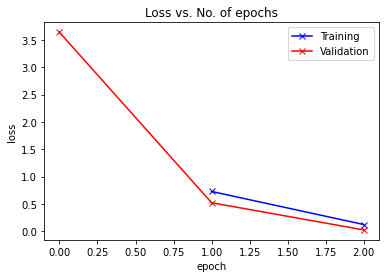

In [84]:
plot_losses(history)

## Learning Rate overtime

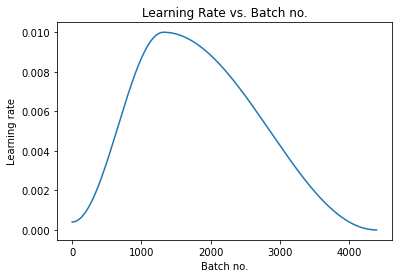

In [90]:
plot_lrs(history)

## Testing model on test data

In [127]:
test_dir = "../input/new-plant-diseases-dataset/test"
test = ImageFolder(test_dir, transform=transforms.ToTensor())

In [128]:
test_images = sorted(os.listdir(test_dir + '/test')) # since images in test folder are in alphabetical order

In [129]:
def predict_image(img, model):
    """Converts image to array and return the predicted class
        with highest probability"""
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label

    return train.classes[preds[0].item()]

Label: AppleCedarRust1.JPG , Predicted: Apple___Cedar_apple_rust


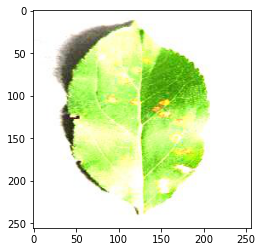

In [130]:
# predicting first image
img, label = test[0]
plt.imshow(img.permute(1, 2, 0))
print('Label:', test_images[0], ', Predicted:', predict_image(img, model))

In [93]:
# getting all predictions (actual label vs predicted)
for i, (img, label) in enumerate(test):
    print('Label:', test_images[i], ', Predicted:', predict_image(img, model))

Label: AppleCedarRust1.JPG , Predicted: Apple___Cedar_apple_rust
Label: AppleCedarRust2.JPG , Predicted: Apple___Cedar_apple_rust
Label: AppleCedarRust3.JPG , Predicted: Apple___Cedar_apple_rust
Label: AppleCedarRust4.JPG , Predicted: Apple___Cedar_apple_rust
Label: AppleScab1.JPG , Predicted: Apple___Apple_scab
Label: AppleScab2.JPG , Predicted: Apple___Apple_scab
Label: AppleScab3.JPG , Predicted: Apple___Apple_scab
Label: CornCommonRust1.JPG , Predicted: Corn_(maize)___Common_rust_
Label: CornCommonRust2.JPG , Predicted: Corn_(maize)___Common_rust_
Label: CornCommonRust3.JPG , Predicted: Corn_(maize)___Common_rust_
Label: PotatoEarlyBlight1.JPG , Predicted: Potato___Early_blight
Label: PotatoEarlyBlight2.JPG , Predicted: Potato___Early_blight
Label: PotatoEarlyBlight3.JPG , Predicted: Potato___Early_blight
Label: PotatoEarlyBlight4.JPG , Predicted: Potato___Early_blight
Label: PotatoEarlyBlight5.JPG , Predicted: Potato___Early_blight
Label: PotatoHealthy1.JPG , Predicted: Potato___h

## Saving the model

In [131]:
# saving the entire model to working directory
PATH = './plant-disease-model-complete.pth'
torch.save(model, PATH)

# References
- [CIFAR10 ResNet Implementation](https://jovian.ai/aakashns/05b-cifar10-resnet)
- [PyTorch docs](https://pytorch.org/)